<a href="https://colab.research.google.com/github/madhurapg/madhurapg.github.io/blob/master/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # EuroSAT Land Use and Land Cover Classification using Deep Learning
 
### Madhura Gurav


In [0]:
!pip install tifffile

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 18.1MB 1.3MB/s 


In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image 
import json 
from skimage.color import rgb2gray 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **S1:**

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Data Preparation

- Convert each RBG image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [0]:
import glob 
import os 
import zipfile
import requests
import io
import cv2
from skimage import color

In [0]:
# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

In [0]:
# get file names and keep those containing ".jpg"
txtfiles = []

for file in z.namelist():
  if '.jpg' in file:
    txtfiles.append(file)

In [0]:
len(txtfiles) #number of images

27000

In [0]:
df = pd.DataFrame(txtfiles) #creating a dataframe of image names

In [0]:
df.head() 

,0
0,2750/River/River_479.jpg
1,2750/River/River_2178.jpg
2,2750/River/River_65.jpg
3,2750/River/River_1643.jpg
4,2750/River/River_191.jpg


In [0]:
 # assigning labels to each image based on image class
 df['img'] = df[0].str.replace(r'2750/', '')
 df[['label', 'drop', 'drop']] = df.img.str.replace("/","_").str.split('_', expand = True)
 df = df.drop(['drop'], axis=1)
 df.head()

,0,img,label
0,2750/River/River_479.jpg,River/River_479.jpg,River
1,2750/River/River_2178.jpg,River/River_2178.jpg,River
2,2750/River/River_65.jpg,River/River_65.jpg,River
3,2750/River/River_1643.jpg,River/River_1643.jpg,River
4,2750/River/River_191.jpg,River/River_191.jpg,River


In [0]:
#converting images to a numpy array
from skimage.io import imread, imshow
imMat = []
for file in z.namelist():
  if '.jpg' in file:
    image = Image.open(z.open(file)) #extract images from zip
    image2 = color.rgb2gray(np.array(image)) #converting to grayscale
    imgFlat = image2.squeeze().flatten() #flatten images
    imMat.append(imgFlat)

In [0]:
dMat = np.array(imMat) #data matrix containing the grayscale images numpy array
dMat.shape

(27000, 4096)

In [0]:
X = dMat
X.shape

(27000, 4096)

In [0]:
df.label.unique() # getting the data labels

array(['River', 'AnnualCrop', 'HerbaceousVegetation', 'Industrial',
       'Residential', 'Highway', 'Pasture', 'Forest', 'SeaLake',
       'PermanentCrop'], dtype=object)

In [0]:
classes = {'AnnualCrop': 1,'Residential': 2, 'Highway': 3, 'Pasture':4,
       'HerbaceousVegetation': 5, 'River': 6, 'Forest': 7, 'Industrial': 8, 'SeaLake': 9,
       'PermanentCrop': 0 }

df["label_num"] = [classes[item] for item in df.label] # assigning a number to each class

In [0]:
y = np.array(df.label_num)
np.set_printoptions(threshold=np.inf)
y.shape #array containing the image labels

(27000,)

In [0]:
#Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

scaler = preprocessing.StandardScaler().fit(X)
XSc = scaler.transform(X) #scaling the data

X_train, X_test, y_train, y_test = train_test_split(XSc, y, stratify = y, train_size = 0.5, random_state=42)

In [0]:
X_train.shape

(13500, 4096)

# **S2:**


- Implement a first deep learning model (M1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

- The classification accuracy on the test data using the M1 model: **0.301**

In [0]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

13500 train samples
13500 test samples


In [0]:
batch_size = 128
num_classes = 10
epochs = 5

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
#Model 1
M1 = Sequential()
M1.add(Dense(10, activation='relu', input_shape=(4096,)))

M1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


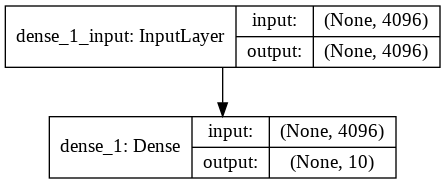

In [0]:
from keras.utils import plot_model

plot_model(M1, show_shapes=True, show_layer_names=True)

In [0]:
M1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/10
13500/13500 [==============================] - 2s 168us/step - loss: 2.8993 - accuracy: 0.2464 - val_loss: 2.3684 - val_accuracy: 0.2825
Epoch 2/10
13500/13500 [==============================] - 1s 48us/step - loss: 2.3328 - accuracy: 0.2836 - val_loss: 2.4687 - val_accuracy: 0.2713
Epoch 3/10
13500/13500 [==============================] - 1s 48us/step - loss: 2.2945 - accuracy: 0.2893 - val_loss: 2.4136 - val_accuracy: 0.2771
Epoch 4/10
13500/13500 [==============================] - 1s 49us/step - loss: 2.2752 - accuracy: 0.2976 - val_loss: 2.5179 - val_accuracy: 0.2961
Epoch 5/10
13500/13500 [==============================] - 1s 48us/step - loss: 2.3437 - accuracy: 0.3141 - val_loss: 2.5077 - val_accuracy: 0.2812
Epoch 6/10
13500/13500 [==============================] - 1s 48us/step - loss: 2.2657 - accuracy: 0.3003 - val_loss: 2.5037 - val_accuracy: 0.2937
Epoch 7/10
13500/13500 [==============================] - 1s 50us/s

In [0]:
#Evaluating Model 1 test loss and accuracy
score = M1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.7663398442444977
Test accuracy: 0.301111102104187


# **S3:**

- Implement a second deep learning model (M2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

- The classification accuracy on the test data using the M2 model: **0.343**

In [0]:
#Model 2
M2 = Sequential()
M2.add(Dense(64, activation='relu', input_shape=(4096,)))
M2.add(Dense(10, activation='relu'))

M2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 262,858
Trainable params: 262,858
Non-trainable params: 0
_________________________________________________________________


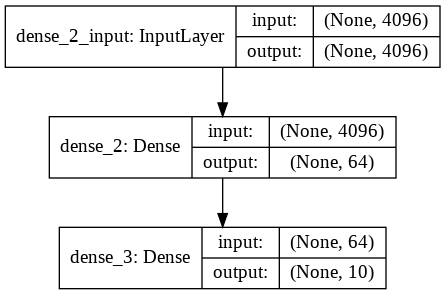

In [0]:
plot_model(M2, show_shapes=True, show_layer_names=True)

In [0]:
M2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/10
13500/13500 [==============================] - 1s 60us/step - loss: 2.7529 - accuracy: 0.2403 - val_loss: 2.1361 - val_accuracy: 0.2804
Epoch 2/10
13500/13500 [==============================] - 1s 52us/step - loss: 1.9535 - accuracy: 0.2902 - val_loss: 1.9081 - val_accuracy: 0.3281
Epoch 3/10
13500/13500 [==============================] - 1s 52us/step - loss: 1.8683 - accuracy: 0.3235 - val_loss: 1.9890 - val_accuracy: 0.3302
Epoch 4/10
13500/13500 [==============================] - 1s 52us/step - loss: 1.8406 - accuracy: 0.3358 - val_loss: 1.9420 - val_accuracy: 0.3480
Epoch 5/10
13500/13500 [==============================] - 1s 54us/step - loss: 1.8430 - accuracy: 0.3363 - val_loss: 1.8791 - val_accuracy: 0.3433
Epoch 6/10
13500/13500 [==============================] - 1s 53us/step - loss: 1.7798 - accuracy: 0.3594 - val_loss: 2.0811 - val_accuracy: 0.3560
Epoch 7/10
13500/13500 [==============================] - 1s 53us/st

In [0]:
#Evaluating Model 2 test loss and accuracy
score = M2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9944696279455114
Test accuracy: 0.3427407443523407


# **S4:**

- Implement a third deep learning model (M3) adding two additional fully connected hidden layers (with arbitrary number of nodes) as well as drop-out layers to the previous model. 

- The classification accuracy on the test data using the M3 model: **0.403**
- **Out of the three models so far, M3 has the best accuracy. M3 has more number of fully connected hidden layers. Also, the dropout layer ensures that there is less overfitting to the train data.**

In [0]:
M3 = Sequential()
M3.add(Dense(64, activation='relu', input_shape=(4096,)))
M3.add(Dropout(0.5))
M3.add(Dense(128, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(10, activation='relu'))

M3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                262208    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

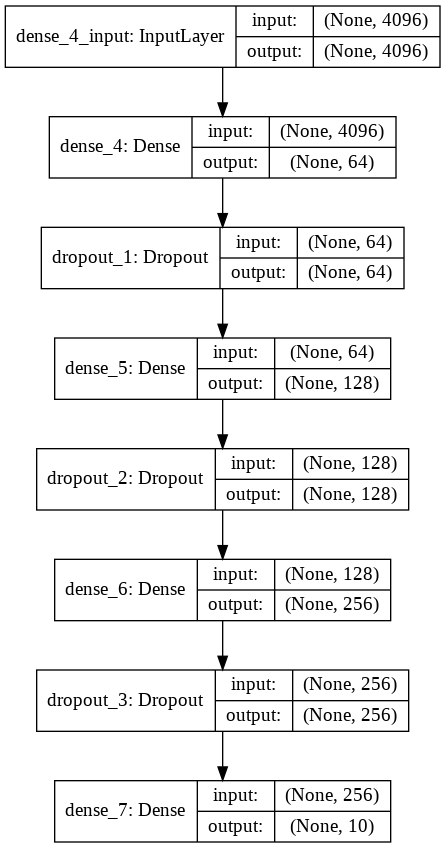

In [0]:
plot_model(M3, show_shapes=True, show_layer_names=True)

In [0]:
M3.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M3.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/10
13500/13500 [==============================] - 1s 75us/step - loss: 2.2137 - accuracy: 0.2286 - val_loss: 1.8681 - val_accuracy: 0.3014
Epoch 2/10
13500/13500 [==============================] - 1s 61us/step - loss: 1.9693 - accuracy: 0.2846 - val_loss: 1.9555 - val_accuracy: 0.2393
Epoch 3/10
13500/13500 [==============================] - 1s 61us/step - loss: 1.9312 - accuracy: 0.3098 - val_loss: 1.8020 - val_accuracy: 0.3328
Epoch 4/10
13500/13500 [==============================] - 1s 59us/step - loss: 1.8939 - accuracy: 0.3260 - val_loss: 1.8001 - val_accuracy: 0.3479
Epoch 5/10
13500/13500 [==============================] - 1s 60us/step - loss: 1.9206 - accuracy: 0.3482 - val_loss: 1.7726 - val_accuracy: 0.3817
Epoch 6/10
13500/13500 [==============================] - 1s 60us/step - loss: 1.8951 - accuracy: 0.3539 - val_loss: 1.7492 - val_accuracy: 0.3864
Epoch 7/10
13500/13500 [==============================] - 1s 60us/st

In [0]:
#Evaluating Model 3  test loss and accuracy
score = M3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7383527513786599
Test accuracy: 0.4031111001968384


# **S5:**

- Using RGB images (without vectorizing them), implement a fourth CNN model (M4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

- The classification accuracy on the test data using the M4 model: **0.486**
- **Increasing the depth of the model and adding more complexity made M4 the best out of the four models so far.**

In [0]:
#Creating the data matrix again but this time for RGB images and without flattening/ vectorizing the images. 
imMat2 = []
for file in z.namelist():
  if '.jpg' in file:
    image = Image.open(z.open(file))
    image2 = np.asarray(image)
    imMat2.append(image2)

In [0]:
dMat2 = np.array(imMat2)
dMat2.shape 

(27000, 64, 64, 3)

In [0]:
X2 = dMat2
X2.shape

(27000, 64, 64, 3)

In [0]:
y2 = np.array(df.label_num)
np.set_printoptions(threshold=np.inf)
y2.shape

(27000,)

In [0]:
#Splitting data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify = y2, train_size = 0.5, random_state=42)

In [0]:
X2_train.shape

(13500, 64, 64, 3)

In [0]:
X2_train = X2_train.astype('float32')
X2_test = X2_test.astype('float32')
X2_train /= 255
X2_test /= 255
print(X2_train.shape[0], 'train samples')
print(X2_test.shape[0], 'test samples')

y2_train = keras.utils.to_categorical(y2_train, num_classes)
y2_test = keras.utils.to_categorical(y2_test, num_classes)

13500 train samples
13500 test samples


In [0]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation

#Model 4
M4 = Sequential()
M4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
M4.add(MaxPooling2D(pool_size=(2, 2))) #32x32
M4.add(Dropout(0.25))
M4.add(Flatten())
M4.add(Dense(64, activation='relu', input_shape=(4096,)))
M4.add(Dropout(0.5))
M4.add(Dense(128, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(256, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(10, activation='relu'))

In [0]:
M4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2097216   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

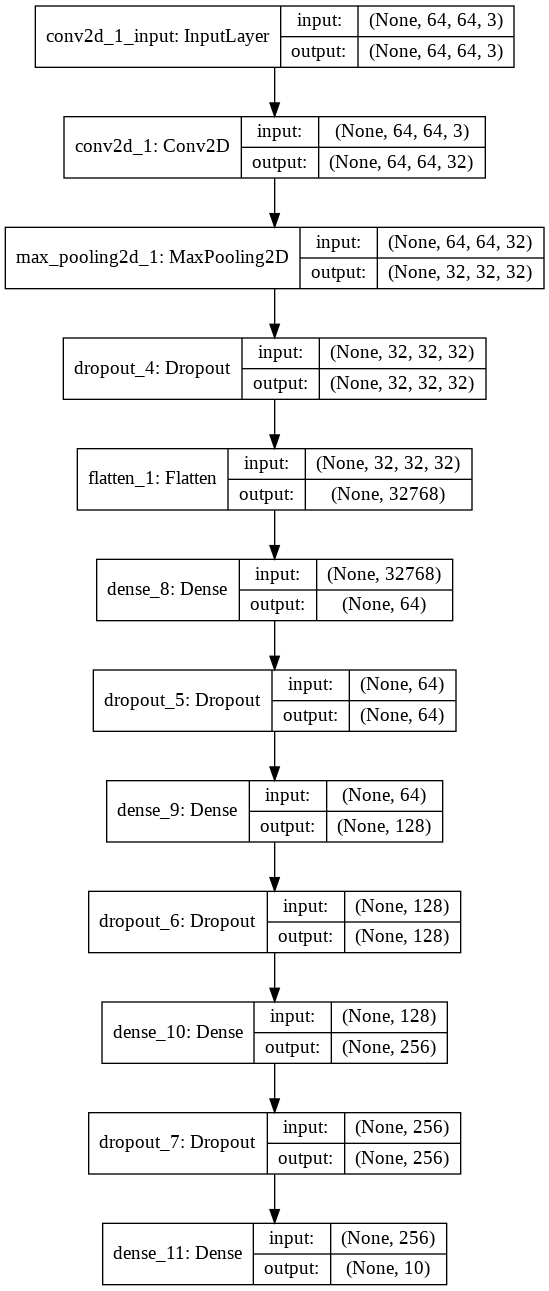

In [0]:
plot_model(M4, show_shapes=True, show_layer_names=True)

In [0]:
y2_test.shape

(13500, 10)

In [0]:
M4.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
history = M4.fit(X2_train, y2_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X2_test, y2_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/10
13500/13500 [==============================] - 2s 161us/step - loss: 2.8239 - accuracy: 0.1164 - val_loss: 2.2416 - val_accuracy: 0.1744
Epoch 2/10
13500/13500 [==============================] - 2s 139us/step - loss: 2.1601 - accuracy: 0.2169 - val_loss: 1.9509 - val_accuracy: 0.2186
Epoch 3/10
13500/13500 [==============================] - 2s 140us/step - loss: 1.9876 - accuracy: 0.2877 - val_loss: 2.0205 - val_accuracy: 0.3264
Epoch 4/10
13500/13500 [==============================] - 2s 139us/step - loss: 1.9901 - accuracy: 0.3286 - val_loss: 1.6469 - val_accuracy: 0.3983
Epoch 5/10
13500/13500 [==============================] - 2s 138us/step - loss: 1.8074 - accuracy: 0.3794 - val_loss: 1.6747 - val_accuracy: 0.4080
Epoch 6/10
13500/13500 [==============================] - 2s 138us/step - loss: 1.7435 - accuracy: 0.3953 - val_loss: 1.6596 - val_accuracy: 0.4257
Epoch 7/10
13500/13500 [==============================] - 2s 1

In [0]:
#Evaluating Model 4 test loss and accuracy
score = M4.evaluate(X2_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3932417881577104
Test accuracy: 0.4864444434642792


# **S6:**

- Using RGB images (without vectorizing them), implement a fifth deep learning model (M5) targeting accuracy that will outperform all previous models. 

- The classification accuracy on the test data using the M5 model: **0.857**

- **Based on the test loss and accuracy values, M5 was the best amongst all the models. The model has additional layers and therefore complexity. Parameter tuning was carried to adjust the epochs, batch size, etc. Data augmentation was carried out which significantly increases the diversity of data available for training models.**

- **Residential and Pasture classes have the highest labeling error.**

In [0]:
X2_train.shape

(13500, 64, 64, 3)

In [0]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation

M5 = Sequential()
M5.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
M5.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2))) #32x32
M5.add(Dropout(0.25))

M5.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2))) #16x16

M5.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2))) #8x8

M5.add(Dropout(0.25))
M5.add(Flatten())

M5.add(Dense(1024, activation='relu'))
M5.add(Dropout(0.25))
M5.add(Dense(4096, activation='relu'))
M5.add(Dense(10, activation='softmax'))

In [0]:
M5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 512)      

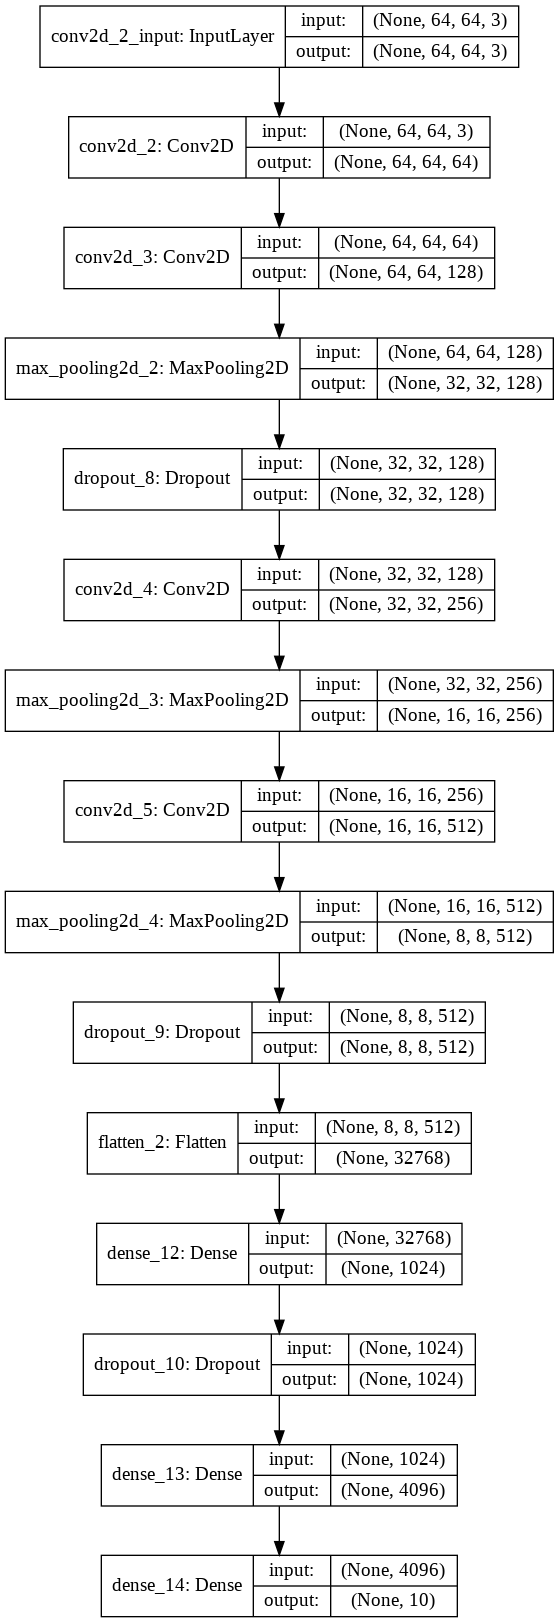

In [0]:
plot_model(M5, show_shapes=True, show_layer_names=True)

In [0]:
M5.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X2_train,
    y2_train,
    batch_size=250,
    )

validation_generator = test_datagen.flow(
    X2_test,
    y2_test,
    batch_size=250,
    )

M5.fit_generator(
    train_generator,
    steps_per_epoch=len(X2_train) // 250,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(X2_test) // 250)

Epoch 1/25
54/54 [==============================] - 22s 409ms/step - loss: 4.1449 - accuracy: 0.1856 - val_loss: 2.0245 - val_accuracy: 0.2852
Epoch 2/25
54/54 [==============================] - 20s 362ms/step - loss: 2.0791 - accuracy: 0.2253 - val_loss: 2.0083 - val_accuracy: 0.2001
Epoch 3/25
54/54 [==============================] - 20s 364ms/step - loss: 1.8877 - accuracy: 0.2674 - val_loss: 1.7712 - val_accuracy: 0.2873
Epoch 4/25
54/54 [==============================] - 19s 361ms/step - loss: 1.7430 - accuracy: 0.3344 - val_loss: 1.9235 - val_accuracy: 0.3127
Epoch 5/25
54/54 [==============================] - 19s 360ms/step - loss: 1.6175 - accuracy: 0.3834 - val_loss: 1.6755 - val_accuracy: 0.3759
Epoch 6/25
54/54 [==============================] - 20s 362ms/step - loss: 1.4303 - accuracy: 0.4804 - val_loss: 1.1356 - val_accuracy: 0.5778
Epoch 7/25
54/54 [==============================] - 19s 359ms/step - loss: 1.3229 - accuracy: 0.5276 - val_loss: 0.9657 - val_accuracy: 0.6403

In [0]:
#Evaluating test loss and test accuracy
score = M5.evaluate(X2_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4371580673500344
Test accuracy: 0.8566666841506958


In [0]:
label_list = df.label.unique()
y_test_obs_tmp = np.argmax(y2_test, axis = 1)
Class_count = np.unique(y_test_obs_tmp, return_counts = True)[1]


y_test_pred_tmp = M5.predict_classes(X2_test)

y_test_obs = [label_list[x] for x in y_test_obs_tmp]
y_test_pred = [label_list[x] for x in y_test_pred_tmp]

acc_df = pd.DataFrame({'Class': y_test_obs, 'y_pred': y_test_pred})
acc_df['correct_preds'] = acc_df.Class == acc_df.y_pred
acc_df = acc_df.groupby(['Class']).sum().reset_index()

acc_df['class_count'] = Class_count
acc_df['class_acc'] = acc_df.correct_preds / acc_df.class_count
acc_df = acc_df.sort_values(by = 'class_acc').reset_index()
  
acc_df

,index,Class,correct_preds,class_count,class_acc
0,7,Residential,747.0,1500,0.498000
1,5,Pasture,954.0,1500,0.636000
2,9,SeaLake,1132.0,1500,0.754667
3,8,River,985.0,1250,0.788000
4,1,Forest,1353.0,1500,0.902000
5,3,Highway,1141.0,1250,0.912800
6,0,AnnualCrop,1218.0,1250,0.974400
7,2,HerbaceousVegetation,1478.0,1500,0.985333
8,4,Industrial,1099.0,1000,1.099000
9,6,PermanentCrop,1458.0,1250,1.166400
